In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
incidents = pd.read_csv('data/cleaned/incidents.csv', index_col=0)
print(f"Incidents shape: {incidents.shape}")
reports = pd.read_csv('data/cleaned/reports.csv')
print(f"Reports shape: {reports.shape}")
resources = pd.read_csv('data/cleaned/resources.csv', index_col=0)
print(f"Resources shape: {resources.shape}")
plt.style.use('fire_style.mplstyle')

Incidents shape: (94099, 31)
Reports shape: (45389, 23)


C:\Users\benja\AppData\Local\Temp\ipykernel_71576\421573068.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  reports = pd.read_csv('data/cleaned/reports.csv')


Resources shape: (480143, 6)


In [3]:
reports['mean_report_date'].iloc[21735]

'2017-03-22 12:45:00.000'

## Merge

In [4]:
merged = incidents.merge(reports, left_on="INCIDENT_IDENTIFIER", right_on="INC_IDENTIFIER")

In [5]:
pd.to_datetime(merged['mean_report_date'], format='ISO8601')

0       2015-05-05 17:52:30
1       2015-05-07 13:00:00
2       2015-05-17 21:00:00
3       2015-05-25 11:30:00
4       2015-05-26 12:00:00
                ...        
45299   2018-07-31 20:17:00
45300   2018-06-11 13:00:00
45301   2018-06-27 04:00:00
45302   2018-07-03 04:00:00
45303   2018-06-18 02:45:00
Name: mean_report_date, Length: 45304, dtype: datetime64[ns]

For each incident, get pairs (day D, incident_area of day D, incident_area of day D+1)


In [6]:
def transform_target(df, fn=None):
  if fn=='sqrt':
    df['incident_area'] = np.sqrt(df['incident_area'])
    df['next_incident_area'] = np.sqrt(df['next_incident_area'])
  elif fn=='log':
    df['incident_area'] = np.log(1+df['incident_area'])
    df['next_incident_area'] = np.log(1+df['next_incident_area'])
  else:
    df['incident_area'] = df['incident_area']
  return df

In [7]:
def create_task_dataset(df, features, transform_target, target='next_incident_area'):
  """Each row will correspond to a data point of the task.

  Arguments:
      df {DataFrame} -- merged dataframe: incidents, reports, resources. A row is a report.
      features {List[str]} -- List of features to use for the task.
      target {str} -- target to predict
  """
  df = df.sort_values(by=['fire_id', 'mean_report_date'])
  df['report_number'] = df.groupby('fire_id').cumcount() + 1
  if target=='next_incident_area':
    df['next_incident_area'] = df.groupby('fire_id')['incident_area'].shift(-1)
    print(len(df))
    df.dropna(subset=['next_incident_area'], inplace=True)
    print(len(df))
  if target=='diff_incident_area':
    next_incident_area = df.groupby('fire_id')['incident_area'].shift(-1)
    df['diff_incident_area'] = next_incident_area - df['incident_area']
    print(len(df))
    df.dropna(subset=['diff_incident_area'], inplace=True)
    print(len(df))
  df = transform_target(df)
  df = df[['fire_id']+ features + [target]]
  cat_cols = ['cause_id', 'month', 'year_y', 'STATUS']
  encoded_df = pd.get_dummies(df, columns=cat_cols)
  return encoded_df

Should get the the reverse operation of this preprocessing to compare:
 postprocessing(target=)

In [8]:
features = ['INC209R_IDENTIFIER', 'report_number', 'incident_area', 'cause_id', 'month', 'year_y', 'STATUS']
task_df = create_task_dataset(df.merge(resources, on='INC209R_IDENTIFIER', how='left'), ['INC209R_IDENTIFIER', 'RESOURCE_PERSONNEL', 'report_number', 'incident_area', 'cause_id', 'month', 'year_y', 'STATUS'], transform_target, target='diff_incident_area')

NameError: name 'df' is not defined

In [7]:
task_df

,fire_id,INC209R_IDENTIFIER,RESOURCE_PERSONNEL,report_number,incident_area,diff_incident_area,cause_id_1.0,cause_id_2.0,cause_id_3.0,cause_id_4.0,...,month_11,month_12,year_y_2014,year_y_2015,year_y_2016,year_y_2017,year_y_2018,STATUS_F,STATUS_I,STATUS_U
1447,2714022,2714023,1.0,1,150.0,0.0,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
1448,2714022,2714023,3.0,2,150.0,0.0,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
1449,2714022,2714023,4.0,3,150.0,0.0,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
1450,2714022,2714023,37.0,4,150.0,125.0,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
1443,2714022,2714037,1.0,5,275.0,0.0,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467379,9276339,9276382,2.0,57,100.0,0.0,False,True,False,False,...,False,False,False,False,False,False,True,True,False,False
467406,9276448,9276458,NaN,1,484.0,2857.0,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False
467405,9276448,9276449,NaN,2,3341.0,70.0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
467408,9276448,9276476,NaN,3,3411.0,-1.0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True


## Train split

In [8]:
task_df.dropna(inplace=True)

In [9]:
unique_ids = task_df['fire_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
train_df = task_df[task_df['fire_id'].isin(train_ids)]
test_df = task_df[task_df['fire_id'].isin(test_ids)]
X_test, y_test = test_df.drop(columns=['fire_id', 'diff_incident_area']), test_df['diff_incident_area']

In [11]:
len(test_df)/len(task_df)

0.20702829642266662

In [12]:
X, y = train_df.drop(columns=['fire_id', 'diff_incident_area']), train_df['diff_incident_area']

<Axes: >

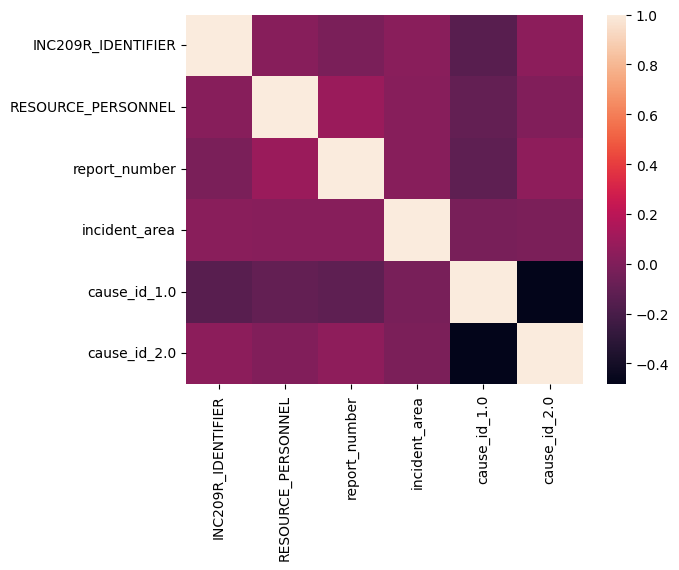

In [13]:
import seaborn as sns
sns.heatmap(X.iloc[:, :6].corr())

In [14]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X, y)
print("Intercept: ", linear_regression_model.intercept_)
print("Coefficients: ", linear_regression_model.coef_)
y_pred = linear_regression_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Linear Regression Model')
plt.show()

NameError: name 'LinearRegression' is not defined

In [15]:
X.iloc[:, 2:]= X.iloc[:, 2:].astype(int)


In [16]:
import statsmodels.api as sm
X2 = sm.add_constant(X)
est = sm.OLS(y.values, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.118
Date:                Thu, 23 Nov 2023   Prob (F-statistic):              0.310
Time:                        13:23:34   Log-Likelihood:            -3.7082e+06
No. Observations:              376499   AIC:                         7.416e+06
Df Residuals:                  376473   BIC:                         7.417e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -24.2193    359

In [100]:
import statsmodels.api as sm
from scipy import stats
X2 = sm.add_constant(X)
est = sm.OLS(y.values, X2)
est2 = est.fit()
print(est2.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

<Axes: >

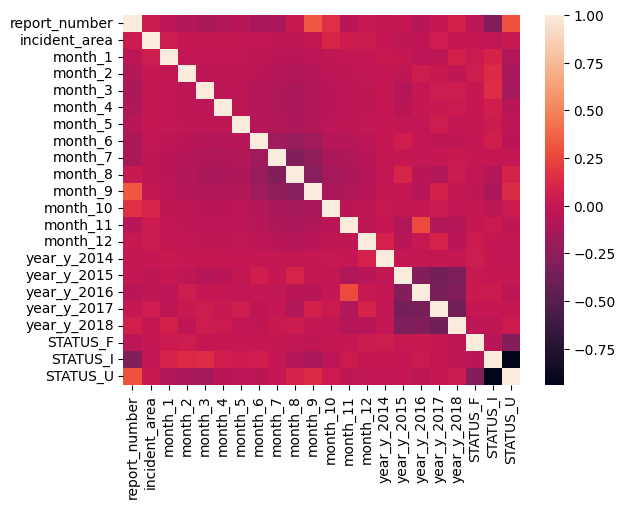

In [99]:
cols_to_include = list(range(2)) + list(range(6, X.shape[1]))
sns.heatmap(X.iloc[:, cols_to_include].corr())

## Scaler on train

In [75]:
scaler = StandardScaler()
target_scaler = StandardScaler()
scaled_df = train_df.copy()
scaled_df.loc[:, 'incident_area'] = scaler.fit_transform(scaled_df[['incident_area']])
scaled_y = target_scaler.fit_transform(scaled_df[['diff_incident_area']]).flatten()

In [69]:
scaled_df[numerical_cols].describe()

,incident_area,diff_incident_area
count,2.953000e+04,2.953000e+04
mean,3.849876e-18,6.367715e+02
std,1.000017e+00,2.251060e+04
min,-5.501534e-02,-2.601403e+06
25%,-5.478527e-02,0.000000e+00
50%,-5.384857e-02,0.000000e+00
75%,-4.693012e-02,7.900000e+01
max,2.625478e+01,2.627860e+06


<Axes: >

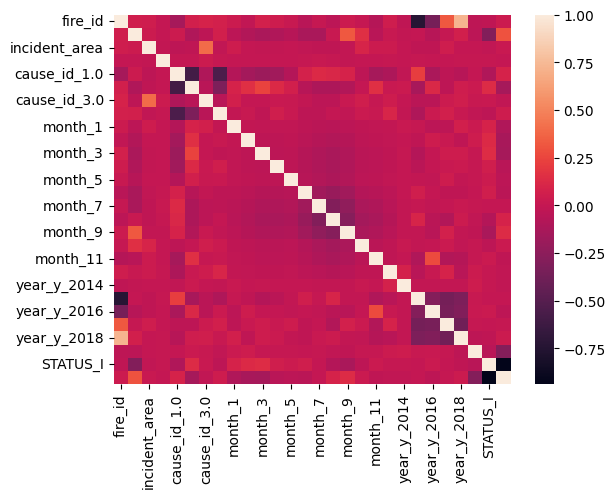

In [71]:
X = scaled_df.drop(columns=['fire_id', 'diff_incident_area'])

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score


Intercept:  0.11376943176451043
Coefficients:  [ 2.34624735e-05 -2.61991984e-02 -1.34227824e-01 -1.23814152e-01
  3.71686135e-01 -1.13644159e-01 -4.33793394e-02 -2.26760328e-02
 -3.55703474e-03 -8.46066715e-03 -1.25402302e-02  2.39940745e-02
  3.20288385e-02  2.22071230e-02 -5.62057324e-03 -1.09570330e-02
  2.25986686e-03  2.67010077e-02 -2.19729295e-02  1.84272211e-02
 -5.58196024e-03  6.39330955e-03  2.73435912e-03  8.63768337e-03
  3.99456581e-03 -1.26322492e-02]
R2:  -113.34896772585788


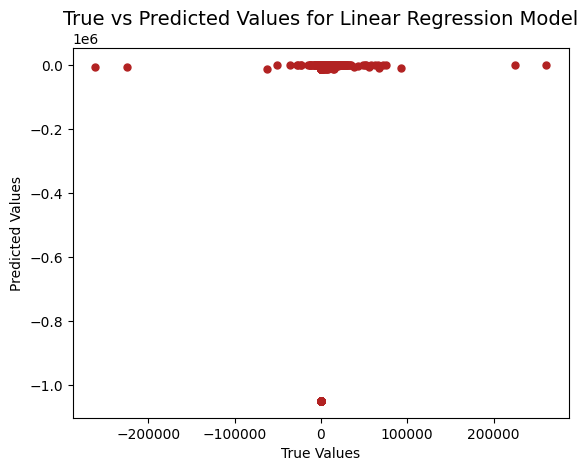

In [74]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X, y)

print("Intercept: ", linear_regression_model.intercept_)
print("Coefficients: ", linear_regression_model.coef_)

# Predict the target variable on the testing data
y_pred = linear_regression_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

plt.scatter(y_test, y_pred)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Linear Regression Model')
plt.show()

In [42]:
scaler.inverse_transform(pd.concat([X_, y_pred]))

array(['incident_area', 'diff_incident_area'], dtype=object)

In [16]:
from sklearn.model_selection import KFold
unique_ids = task_df['fire_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
train_df = task_df[task_df['fire_id'].isin(train_ids)]
test_df = task_df[task_df['fire_id'].isin(test_ids)]

def train_model(model, X, y, kf):
  for train, test in kf.split(X):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


In [38]:
cv_scores = cross_val_score(linear_regression_model, X, y, cv=10, scoring='r2')